Using device: cuda
Model loaded!
Testing on: D2015.11.30_S1393_I141_2_frame0095
Number of masks: 2
Predicted 2 masks


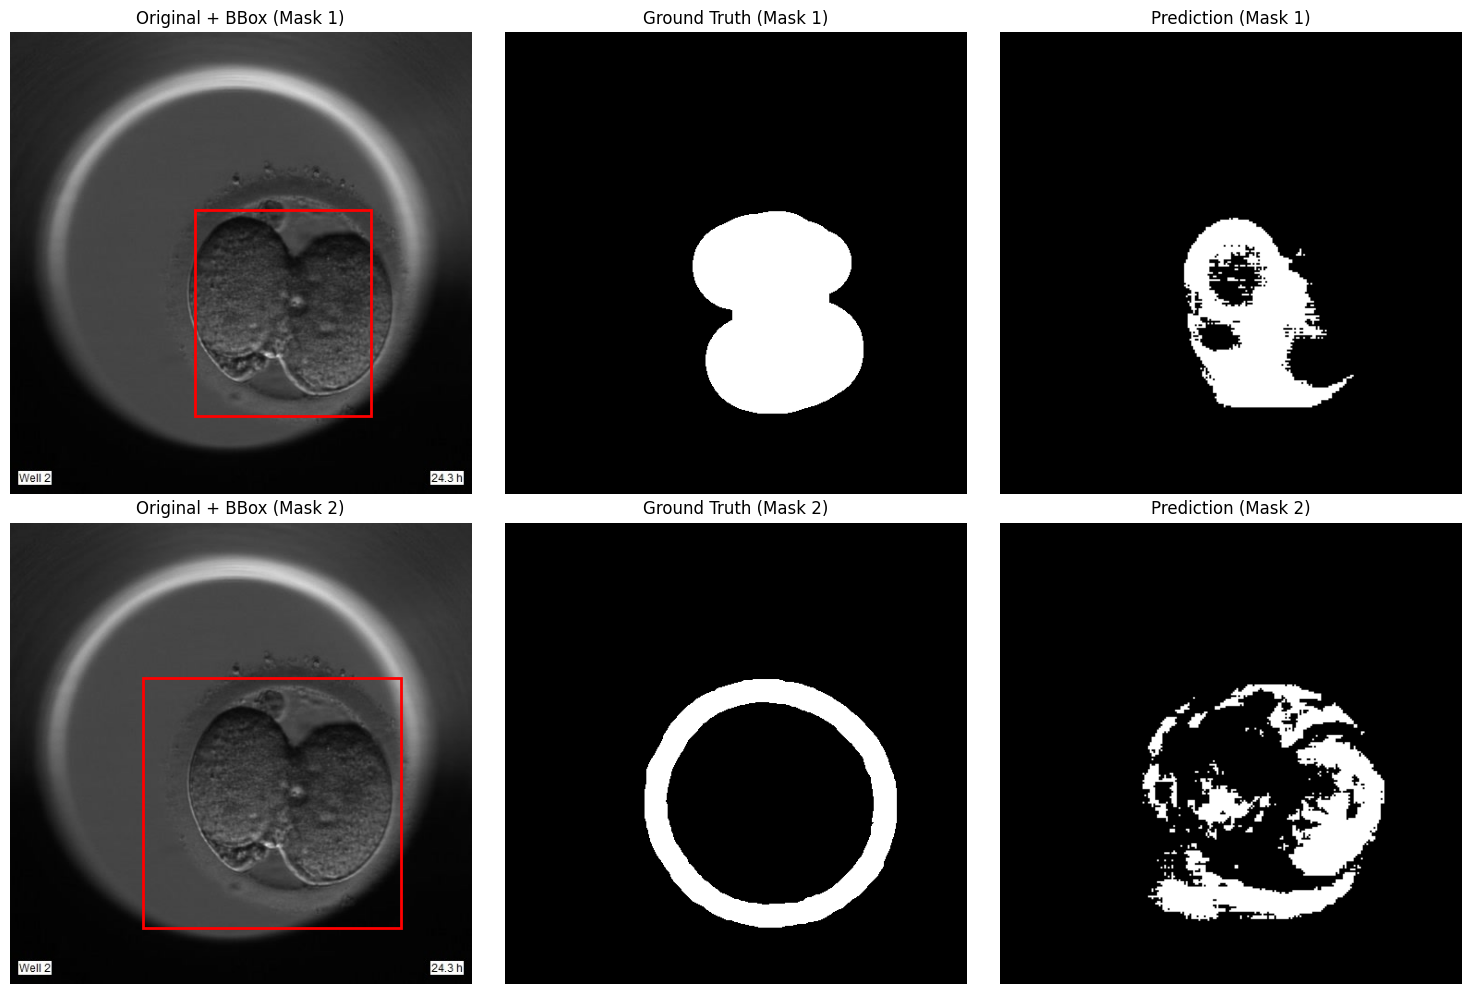

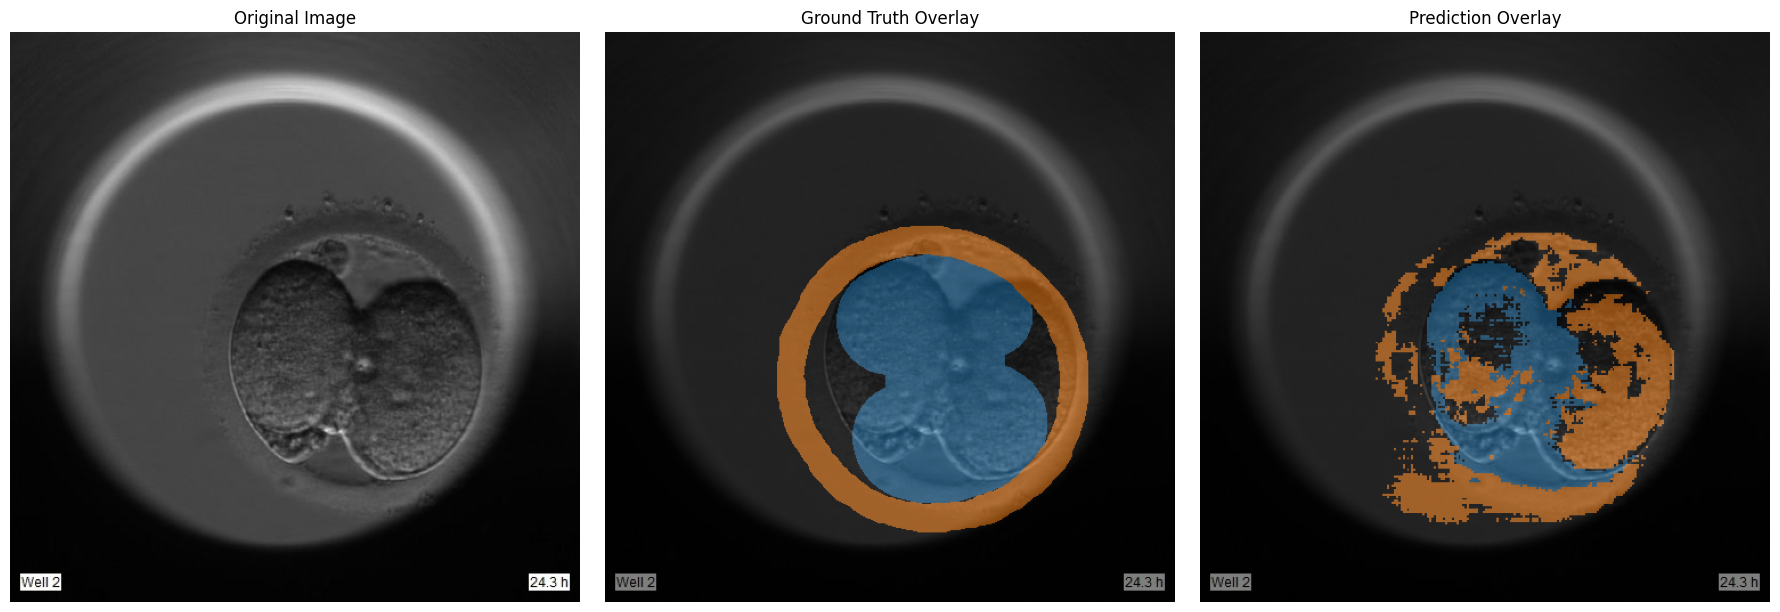


Metrics per mask:
Mask 1: Dice=0.6980, IoU=0.5361
Mask 2: Dice=0.3756, IoU=0.2312

Average: Dice=0.5368, IoU=0.3837


In [27]:
# MedSAM Inference Notebook

# Cell 1: Imports
import torch
import numpy as np
import matplotlib.pyplot as plt
from transformers import SamModel, SamProcessor
from PIL import Image
from pathlib import Path
from loaders.image_multi import ImageLoader 
import random 
# Cell 2: Load Model
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

model_path = "./medsam_finetuned"
model = SamModel.from_pretrained(model_path).to(device)
processor = SamProcessor.from_pretrained(model_path)
model.eval()
print("Model loaded!")

# Cell 3: Helper Functions
def get_bounding_box(mask):
    """Extract bounding box from mask"""
    y_indices, x_indices = np.where(mask > 0)
    if len(y_indices) == 0:
        return None
    x_min, x_max = np.min(x_indices), np.max(x_indices)
    y_min, y_max = np.min(y_indices), np.max(y_indices)
    return [x_min, y_min, x_max, y_max]

def predict_masks(image_path, mask_paths, model, processor, device):
    """Predict masks for an image given bounding boxes from ground truth"""
    # Load image
    image = Image.open(image_path).convert("RGB")
    
    # Get bounding boxes from ground truth masks
    boxes = []
    for mask_path in mask_paths:
        mask = np.array(Image.open(mask_path).convert("L"))
        bbox = get_bounding_box(mask)
        if bbox:
            boxes.append(bbox)
    
    if not boxes:
        return None, None
    
    # Process inputs
    inputs = processor(image, input_boxes=[[boxes]], return_tensors="pt").to(device)
    
    # Predict
    with torch.no_grad():
        outputs = model(**inputs, multimask_output=False)
    
    # Get predicted masks
    pred_masks = outputs.pred_masks.squeeze().cpu()
    if pred_masks.dim() == 2:
        pred_masks = pred_masks.unsqueeze(0)
    
    # Apply sigmoid
    pred_masks = torch.sigmoid(pred_masks).numpy()
    
    # Threshold to binary
    pred_masks_binary = (pred_masks > 0.5).astype(np.uint8)
    
    return pred_masks_binary, boxes


base_dir = "/run/media/capitan/Emu/data_multi_roi/extracted_frames"
loader = ImageLoader(base_dir)
train_samples, test_samples = loader.split_data(test_ratio=0.2)

# Get a test sample
sample = random.choice(test_samples)
print(f"Testing on: {sample['id']}_frame{sample['frame']}")
print(f"Number of masks: {len(sample['masks'])}")

image_path = sample["image"]
mask_paths = sample["masks"]

# Cell 5: Run Inference
pred_masks, boxes = predict_masks(image_path, mask_paths, model, processor, device)

if pred_masks is None:
    print("No valid masks found!")
else:
    print(f"Predicted {len(pred_masks)} masks")

# Cell 6: Load Ground Truth
image = np.array(Image.open(image_path).convert("RGB"))
gt_masks = []
for mask_path in mask_paths:
    mask = np.array(Image.open(mask_path).convert("L"))
    gt_masks.append((mask > 127).astype(np.uint8))

# Cell 7: Visualize Results
num_masks = len(pred_masks)
fig, axes = plt.subplots(num_masks, 3, figsize=(15, 5 * num_masks))

# Handle single mask case
if num_masks == 1:
    axes = axes.reshape(1, -1)

for i in range(num_masks):
    # Original image with bounding box
    ax1 = axes[i, 0]
    ax1.imshow(image)
    bbox = boxes[i]
    rect = plt.Rectangle(
        (bbox[0], bbox[1]), 
        bbox[2] - bbox[0], 
        bbox[3] - bbox[1],
        fill=False, 
        edgecolor='red', 
        linewidth=2
    )
    ax1.add_patch(rect)
    ax1.set_title(f"Original + BBox (Mask {i+1})")
    ax1.axis('off')
    
    # Ground truth mask
    ax2 = axes[i, 1]
    ax2.imshow(gt_masks[i], cmap='gray')
    ax2.set_title(f"Ground Truth (Mask {i+1})")
    ax2.axis('off')
    
    # Predicted mask
    ax3 = axes[i, 2]
    ax3.imshow(pred_masks[i], cmap='gray')
    ax3.set_title(f"Prediction (Mask {i+1})")
    ax3.axis('off')

plt.tight_layout()
plt.show()

# Cell 8: Overlay Comparison (FIXED)
from scipy.ndimage import zoom

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Resize predicted masks to match image size
pred_masks_resized = []
for mask in pred_masks:
    # Calculate zoom factors
    zoom_factors = (image.shape[0] / mask.shape[0], image.shape[1] / mask.shape[1])
    mask_resized = zoom(mask, zoom_factors, order=0)  # order=0 for nearest neighbor
    pred_masks_resized.append(mask_resized)

# Original image
axes[0].imshow(image)
axes[0].set_title("Original Image")
axes[0].axis('off')

# Ground truth overlay
axes[1].imshow(image)
combined_gt = np.zeros_like(image)
for i, mask in enumerate(gt_masks):
    color = plt.cm.tab10(i)[:3]
    combined_gt[mask > 0] = (np.array(color) * 255).astype(np.uint8)
axes[1].imshow(combined_gt, alpha=0.5)
axes[1].set_title("Ground Truth Overlay")
axes[1].axis('off')

# Prediction overlay
axes[2].imshow(image)
combined_pred = np.zeros_like(image)
for i, mask in enumerate(pred_masks_resized):
    color = plt.cm.tab10(i)[:3]
    combined_pred[mask > 0] = (np.array(color) * 255).astype(np.uint8)
axes[2].imshow(combined_pred, alpha=0.5)
axes[2].set_title("Prediction Overlay")
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Cell 9: Calculate Metrics
from skimage.transform import resize

def resize_mask(mask, target_shape):
    return resize(mask, target_shape, preserve_range=True, anti_aliasing=False).astype(mask.dtype)

# Ensure both masks have the same shape before computing metrics
def dice_coefficient(pred, gt):
    if pred.shape != gt.shape:
        gt = resize_mask(gt, pred.shape)
    intersection = np.sum(pred * gt)
    return (2.0 * intersection) / (np.sum(pred) + np.sum(gt) + 1e-8)

def iou_score(pred, gt):
    if pred.shape != gt.shape:
        gt = resize_mask(gt, pred.shape)
    intersection = np.sum(pred * gt)
    union = np.sum(pred) + np.sum(gt) - intersection
    return intersection / (union + 1e-8)

print("\nMetrics per mask:")
for i in range(num_masks):
    dice = dice_coefficient(pred_masks[i], gt_masks[i])
    iou = iou_score(pred_masks[i], gt_masks[i])
    print(f"Mask {i+1}: Dice={dice:.4f}, IoU={iou:.4f}")

avg_dice = np.mean([dice_coefficient(pred_masks[i], gt_masks[i]) for i in range(num_masks)])
avg_iou = np.mean([iou_score(pred_masks[i], gt_masks[i]) for i in range(num_masks)])
print(f"\nAverage: Dice={avg_dice:.4f}, IoU={avg_iou:.4f}")